In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysr
from sklearn.linear_model import LinearRegression
from scipy.integrate import solve_ivp

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [20]:
# Load the dataset
data = pd.read_csv("synthetic_data.csv")

# Display the first few rows
print("First few rows of the dataset:")
print(data.head())
    
t = data["t"].values
A2 = data["A2"].values  

print("Shape of t:", t.shape)
print("Shape of A2:", A2.shape)

First few rows of the dataset:
         A2    t
0  0.000000  0.0
1  0.172023  0.1
2  0.311163  0.2
3  0.427726  0.3
4  0.520069  0.4
Shape of t: (1010,)
Shape of A2: (1010,)


In [22]:
# Fit symbolic regression model using PySR
symbolic_regressor = pysr.PySRRegressor(
    populations=500,
    population_size=40,
    niterations=20, 
    ncycles_per_iteration=40,
    optimizer_iterations=50,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["log", "exp"],
    parsimony=0.004,
    progress=True,
    random_state=0,
    optimizer_nrestarts=2,
    procs=14,
    model_selection = "score",
    temp_equation_file = True,    
)

time = t.reshape(-1, 1)


# Fit the model for dy/dt
symbolic_regressor.fit(time[0:101], A2[0:101])

C:\Users\wenzh\AppData\Roaming\Python\Python311\site-packages\pysr\sr.py:2766: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
C:\Users\wenzh\AppData\Roaming\Python\Python311\site-packages\pysr\sr.py:1835: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.320e+03
Progress: 148 / 10000 total iterations (1.480%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.312e-02  1.594e+01  y = 0.6814
5           1.923e-02  4.607e-02  y = (x₀ * -0.021394) - -0.78838
6           1.809e-02  6.077e-02  y = (x₀ / exp(x₀)) + 0.58253
7           1.636e-02  1.008e-01  y = (0.049275 / (-0.064975 - x₀)) - -0.71054
10          1.592e-02  9.001e-03  y = ((x₀ * exp(-0.055229 - x₀)) * x₀) - -0.41419
12          1.350e-02  8.253e-02  y = ((exp((x₀ + -0.35395) * -4.1495) + -4.0284) / 5.3192) ...
                                      * -0.92896
───────────────────────────────────────────────────────────────────────────────────────────────────
══════════════════════════════════════════════════════════════════════════════════

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          0.6813984   
	1         4.607028e-02                    (x0 + -36.84634) * -0.021396684   
	2         2.990060e-01                   0.7064924 - exp(x0 * -5.0201144)   
	3         3.610202e-02               log(2.015612 - exp(x0 * -3.3882039))   
	4         1.354300e+00         x0 * (exp(x0 * -0.4659877) - -0.046853118)   
	5   >>>>  3.197041e+00       exp(x0 / -15.1592865) - exp(x0 * -2.0669248)   
	6         1.177032e-01  (0.97910076 - exp(x0 / -0.46978256)) + (x0 * -...   
	7         9.915868e-01  (exp(x0 / -13.833754) - exp(x0 * -1.9041979)) ...   
	8         4.305957e-04  ((exp(x0 * -1.9066507) - exp(x0 * -0.07226867)...   
	9         8.701465e-03  (21.063095 / ((x0 + (7.770854 / ((x0 + 0.16649...   
	10        4.441036e-03  (((x0 + 4.216698) / ((x0 * ((x0 * 1.6142772) -...   
	11        5.518259e-03  log((2.836543 / (((x0 + 1.7198479) / (x0 + -0....   
	12        2.628413e-06  log(((x0 + 3.238221) / (((x0 + 4.2771535) / ((...   
	13        6.936885e-07  log(((x0 + 3.2301805) / (((x0 + 4.2980504) / (...   
	14        4.430995e-05  (((x0 + 1.3222357) / (x0 + (((x0 + (x0 + 0.862...   
	15        1.622023e-03  (log(x0 + 0.63054824) / (x0 + (((x0 + (x0 + 0....   
	
	        loss  complexity  
	0   0.023119           1  
	1   0.019228           5  
	2   0.014259           6  
	3   0.013753           7  
	4   0.003550           8  
	5   0.000145           9  
	6   0.000129          10  
	7   0.000048          11  
	8   0.000048          13  
	9   0.000047          16  
	10  0.000046          17  
	11  0.000046          18  
	12  0.000046          22  
	13  0.000046          24  
	14  0.000046          29  
	15  0.000046          30  
]

  - C:\\Users\\wenzh\\AppData\\Local\\Temp\\tmpxgdyv6cc\20250130_134539_u5D22c\hall_of_fame.csv


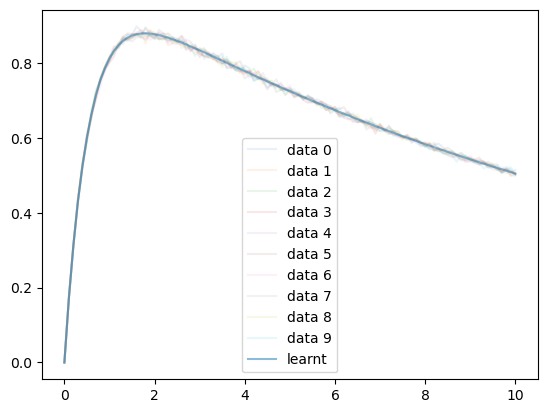

In [45]:
# Define the ODE system
def A2_fitted(t):
    A2 = (np.exp(t / -13.834) - np.exp(t * -1.9042)) / 0.96141
    return A2

# Define time points
T = np.linspace(0, 10, 101)

A2SR = A2_fitted(T)
for i in range(0,10):  
    plt.plot(T, A2[i*101:i*101+101], alpha=0.1, label = f"data {i}")
plt.plot(T, A2SR, alpha=0.5, label = "learnt")

plt.legend()
plt.show()